In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
gdf = gpd.read_parquet("merged_data.parquet").rename(columns={
        'LSOA code (2021)': 'LSOA code',
        'date': 'period',
        'Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)': 'imd_rank',
        'Burglaries amount': 'burglaries'
    })

In [3]:

def downcast_numeric(df: pd.DataFrame) -> pd.DataFrame:
    # 1. downcast integers
    int_cols = df.select_dtypes(include=['int64']).columns
    df[int_cols] = (
        df[int_cols]
        .apply(pd.to_numeric, downcast='integer')
    )
    
    # 2. downcast floats
    float_cols = df.select_dtypes(include=['float64']).columns
    df[float_cols] = (
        df[float_cols]
        .apply(pd.to_numeric, downcast='float')
    )

    return df


codes, uniques = pd.factorize(gdf["LSOA code"], sort=False)
name_to_code = {name: code for code, name in enumerate(uniques)}
code_to_name = dict(enumerate(uniques))

gdf["occupation_idx"] = gdf["LSOA code"].map(name_to_code)
gdf = downcast_numeric(gdf.drop(columns=["LSOA code"]))
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 858968 entries, 0 to 858967
Data columns (total 63 columns):
 #   Column                                                                         Non-Null Count   Dtype         
---  ------                                                                         --------------   -----         
 0   period                                                                         858968 non-null  datetime64[ns]
 1   imd_rank                                                                       858968 non-null  float32       
 2   Income Rank (where 1 is most deprived)                                         858968 non-null  float32       
 3   Employment Rank (where 1 is most deprived)                                     858968 non-null  float32       
 4   Education, Skills and Training Rank (where 1 is most deprived)                 858968 non-null  float32       
 5   Health Deprivation and Disability Rank (where 1 is most deprived

In [4]:
static = {
   "Education locations", "Emergency locations", "Entertainment locations",
   "Food locations", "Leisure locations", "Parking locations", "Shopping locations",
   "Public transport locations", "Dwelling type|Flat, maisonette or apartment (%)",
   "Ethnic Group|Asian/Asian British (%)", "Ethnic Group|BAME (%)", "Ethnic Group|Black/African/Caribbean/Black British (%)",
   "Ethnic Group|Mixed/multiple ethnic groups (%)", "Ethnic Group|Other ethnic group (%)",
   "Ethnic Group|White (%)", "Household Composition|% Couple household with dependent children",
   "Household Composition|% Couple household without dependent children",
   r"Household Composition|% Lone parent household",
    "Household Composition|% One person household",
    "Household Composition|% Other multi person household",
    "Households|All households", "Tenure|Owned outright (%)",
    "Tenure|Owned with a mortgage or loan (%)", "Tenure|Private rented (%)",
    "Tenure|Social rented (%)", "Car or van availability|1 car or van in household (%)",
    "Car or van availability|2 cars or vans in household (%)",
    "Car or van availability|3 cars or vans in household (%)",
    "Car or van availability|4 or more cars or vans in household (%)",
    "Car or van availability|Cars per household",
    "Car or van availability|No cars or vans in household (%)",
    "Public Transport Accessibility Levels|% 0-1 (poor access)|Level3_65",       
    "Public Transport Accessibility Levels|% 2-3 (average access)|Level3_66",       
    "Public Transport Accessibility Levels|% 4-6 (good access)|Level3_67",       
    "Public Transport Accessibility Levels|Average Score|Level3_64",       
    "Public Transport Accessibility Levels|Number of people in each PTAL level:|0",       
    "Public Transport Accessibility Levels|Number of people in each PTAL level:|1a",       
    "Public Transport Accessibility Levels|Number of people in each PTAL level:|1b",       
    "Public Transport Accessibility Levels|Number of people in each PTAL level:|2",       
    "Public Transport Accessibility Levels|Number of people in each PTAL level:|3",       
    "Public Transport Accessibility Levels|Number of people in each PTAL level:|4",       
    "Public Transport Accessibility Levels|Number of people in each PTAL level:|5",       
    "Public Transport Accessibility Levels|Number of people in each PTAL level:|6a",       
    "Public Transport Accessibility Levels|Number of people in each PTAL level:|6b",
}

dynamic = set(gdf.drop(columns=["period", "geometry", "occupation_idx", "burglaries"]).columns) - set(static)

In [5]:
t0 = gdf['period'].min()
# convert each period to the number of months since t0
time_idx = (
    (gdf['period'].dt.year  - t0.year) * 12
  + (gdf['period'].dt.month - t0.month)
)
# center & scale
gdf['time_s'] = (time_idx - time_idx.mean()) / time_idx.std()
gdf['month_sin'] = np.sin(2*np.pi*gdf['period'].dt.month/12)
gdf['month_cos'] = np.cos(2*np.pi*gdf['period'].dt.month/12)

lockdown_start = pd.Timestamp("2020-03-23") 
lockdown_cutoff = pd.Timestamp("2020-03-01")

restrictions_end = pd.Timestamp("2022-02-24")
post_corona_start = restrictions_end + pd.Timedelta(days=1)

gdf["during_corona"] = (
    (gdf["period"] >= lockdown_cutoff) &
    (gdf["period"] <= restrictions_end)
).astype("int8")
gdf["post_corona"] = (gdf["period"] >= post_corona_start).astype("int8")
# Temporal trend
gdf['lag_1']  = gdf.groupby('occupation_idx', observed=True)['burglaries'].shift(1)
gdf['lag_2']  = gdf.groupby('occupation_idx', observed=True)['burglaries'].shift(2)
gdf['lag_3']  = gdf.groupby('occupation_idx', observed=True)['burglaries'].shift(3)
gdf['lag_12'] = gdf.groupby('occupation_idx', observed=True)['burglaries'].shift(12)

# Simple space
gdf["area"] = gdf.geometry.area


In [6]:
# 1a. Keep only one geometry per occupation_idx (drop duplicate footprints).
unique_geom = (
    gdf[["occupation_idx", "geometry"]]
    .drop_duplicates(subset=["occupation_idx"])
    .reset_index(drop=True)
)

# 1b. Apply buffer(0) to clean any invalid polygons (slivers, self-intersections, etc.).
unique_geom["geometry"] = unique_geom["geometry"].buffer(0)

# 1c. Turn it into a proper GeoDataFrame and copy the CRS from gdf_time.
unique_geom = gpd.GeoDataFrame(
    unique_geom[["occupation_idx", "geometry"]],
    geometry="geometry",
    crs=gdf.crs
)

# 1d. OPTIONAL: If your original CRS is geographic (EPSG:4326),
# you’ll typically want a projected CRS (meters) when computing areas/lengths.
# For example, to Web-Mercator (EPSG:3857):
# unique_geom = unique_geom.to_crs(epsg=3857)

# 1e. Compute each footprint’s area (in the projected CRS units, e.g. m²).
unique_geom["area"] = unique_geom.geometry.area

# 1f. Make occupation_idx the index, so that building a spatial index yields 
#     neighbors keyed by occupation_idx directly.
unique_geom = unique_geom.set_index("occupation_idx")


In [7]:
# 2a. Build the spatial index (R-tree) on the buffered geometries:
sindex = unique_geom.sindex

# 2b. For each occupation_idx, find all occupation_idx neighbors that touch it:
neighbor_dict = {}  # will map: occupation_idx → [neighbor_occ1, neighbor_occ2, ...]

for occ_i, geom_i in unique_geom.geometry.items():
    # 2b.1. Bounding‐box candidates (very fast filter):
    possible_matches = list(sindex.intersection(geom_i.bounds))
    # 2b.2. Keep only those that truly touch (and drop itself):
    actual_neighbors = [
        occ_j
        for occ_j in possible_matches
        if (occ_j != occ_i and geom_i.touches(unique_geom.geometry.loc[occ_j]))
    ]
    neighbor_dict[occ_i] = actual_neighbors

# Now neighbor_dict[101] might look like [102, 103], etc.


In [8]:
unique_geom["n_neighbors"] = unique_geom.index.map(lambda i: len(neighbor_dict[i]))

In [9]:
shared_lengths = []

for occ_i, geom_i in unique_geom.geometry.items():
    total_len = 0.0
    for occ_j in neighbor_dict[occ_i]:
        shared_line = geom_i.intersection(unique_geom.geometry.loc[occ_j])
        total_len += shared_line.length
    shared_lengths.append(total_len)

unique_geom["shared_length"] = shared_lengths


In [10]:
# Prepare a small DataFrame of static attributes:
static_cols = unique_geom[["n_neighbors", "shared_length"]].reset_index()

# Merge onto gdf_time by occupation_idx:
gdf_time = gdf.merge(static_cols, on="occupation_idx", how="left")


In [11]:
# 5a. Initialize the new columns with default 0.0:
gdf_time["lag1_sum_neighbors"]    = 0.0
gdf_time["lag1_mean_neighbors"]   = 0.0
gdf_time["lag1_median_neighbors"] = 0.0

# 5b. For each time period, build a small Series mapping occupation_idx → lag_1 at that time.
for ts, sub in tqdm(gdf_time.groupby("time_s"), desc="Processing time slices"):
    # sub is the subset of gdf_time with time_s == ts.
    # Create a Series: index = occupation_idx, value = lag_1
    lag1_map = sub.set_index("occupation_idx")["lag_1"]
    
    # Loop through every row in this time‐slice:
    for idx, row in sub.iterrows():
        occ_i = row["occupation_idx"]
        neighs = neighbor_dict.get(occ_i, [])
        
        # Look up each neighbor’s lag_1 in lag1_map.  If some neighbor is not in lag1_map, reindex → NaN → dropna:
        neigh_vals = lag1_map.reindex(neighs).dropna().values
        
        if len(neigh_vals) > 0:
            s   = float(np.sum(neigh_vals))
            m   = float(np.mean(neigh_vals))
            med = float(np.median(neigh_vals))
        else:
            # No neighbors present at this time slice:
            s = m = med = 0.0
        
        # Write those back into the main gdf_time at row index `idx`:
        gdf_time.at[idx, "lag1_sum_neighbors"]    = s
        gdf_time.at[idx, "lag1_mean_neighbors"]   = m
        gdf_time.at[idx, "lag1_median_neighbors"] = med


Processing time slices:   0%|          | 0/172 [00:00<?, ?it/s]

In [12]:
gdf_time[["lag1_sum_neighbors", "lag1_mean_neighbors", "lag1_median_neighbors"]]

,lag1_sum_neighbors,lag1_mean_neighbors,lag1_median_neighbors
0,0.0,0.000000,0.0
1,10.0,2.000000,1.0
2,17.0,3.400000,4.0
3,17.0,3.400000,1.0
4,15.0,3.000000,3.0
...,...,...,...
858963,11.0,1.833333,1.0
858964,14.0,2.333333,2.5
858965,12.0,2.000000,2.5
858966,8.0,1.333333,1.5


In [13]:
matrix = gdf_time.dropna(subset=["lag_12"]).copy()
matrix = matrix.drop(columns=["geometry", "period"])
matrix = downcast_numeric(matrix)
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Index: 799040 entries, 12 to 858967
Data columns (total 76 columns):
 #   Column                                                                         Non-Null Count   Dtype  
---  ------                                                                         --------------   -----  
 0   imd_rank                                                                       799040 non-null  float32
 1   Income Rank (where 1 is most deprived)                                         799040 non-null  float32
 2   Employment Rank (where 1 is most deprived)                                     799040 non-null  float32
 3   Education, Skills and Training Rank (where 1 is most deprived)                 799040 non-null  float32
 4   Health Deprivation and Disability Rank (where 1 is most deprived)              799040 non-null  float32
 5   Crime Rank (where 1 is most deprived)                                          799040 non-null  float32
 6   Barriers to Hous

In [14]:
static.union({"shared_length", "n_neighbors", "area"})
seasonal = {
    "month_sin", "month_cos", "during_corona", "post_corona"
}
time_trend = {
    "time_s"
}
temporal = {
    "lag_1", "lag_2", "lag_3", "lag_12"
}
spatial = {
    "lag1_sum_neighbors", "lag1_mean_neighbors", "lag1_median_neighbors"
}

In [15]:
matrix.describe()

,imd_rank,Income Rank (where 1 is most deprived),Employment Rank (where 1 is most deprived),"Education, Skills and Training Rank (where 1 is most deprived)",Health Deprivation and Disability Rank (where 1 is most deprived),Crime Rank (where 1 is most deprived),Barriers to Housing and Services Rank (where 1 is most deprived),Living Environment Rank (where 1 is most deprived),burglaries,Education locations,...,lag_1,lag_2,lag_3,lag_12,area,n_neighbors,shared_length,lag1_sum_neighbors,lag1_mean_neighbors,lag1_median_neighbors
count,799040.000000,799040.000000,799040.000000,799040.000000,799040.000000,799040.000000,799040.000000,799040.000000,799040.00000,799040.000000,...,799040.000000,799040.000000,799040.000000,799040.000000,7.990400e+05,799040.000000,799040.000000,799040.000000,799040.000000,799040.000000
mean,13791.617188,13304.645508,16019.570312,19240.382812,18252.402344,10740.275391,8193.372070,9963.663086,1.24089,0.651181,...,1.244642,1.248218,1.250233,1.277485,3.153013e+05,5.935122,2253.101074,7.619407,1.288027,1.022028
std,8462.970703,8742.556641,9003.304688,8605.000977,8931.767578,7342.380371,6710.675781,6451.983398,1.67309,1.005428,...,1.671886,1.670627,1.668503,1.654696,6.255037e+05,1.608759,1230.124756,6.232407,1.001319,1.082508
min,17.000000,11.000000,23.000000,50.000000,26.000000,11.000000,1.000000,1.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.253474e+03,1.000000,246.668930,0.000000,0.000000,0.000000
25%,6797.000000,6167.000000,8613.000000,12789.000000,11259.000000,4615.000000,2760.000000,4886.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.221809e+05,5.000000,1519.717651,4.000000,0.666667,0.000000
50%,12392.000000,11752.000000,15303.000000,19577.000000,18475.000000,9560.000000,6449.000000,8902.000000,1.00000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.959505e+05,6.000000,1977.150024,6.000000,1.142857,1.000000
75%,20279.000000,19290.000000,23295.000000,26591.000000,25956.000000,15711.500000,11935.000000,14202.000000,2.00000,1.000000,...,2.000000,2.000000,2.000000,2.000000,3.174380e+05,7.000000,2626.217041,10.000000,1.666667,1.500000
max,32616.000000,32833.000000,32841.000000,32844.000000,32844.000000,32792.000000,31786.000000,30341.000000,50.00000,26.000000,...,50.000000,50.000000,50.000000,50.000000,1.601233e+07,20.000000,20684.619141,146.000000,23.000000,23.000000


# Training the model

# Pyro test

In [16]:
matrix      = matrix[matrix['time_s'] <  matrix['time_s'].max()].copy()
next_month  = matrix[matrix['time_s'] == matrix['time_s'].max()].copy()

print("Training months:", matrix['time_s'].min(), "→", matrix['time_s'].max())
print("Forecast month:", next_month['time_s'].unique())

Training months: -1.4803234 → 1.7018684
Forecast month: [1.7018684]


In [17]:
import torch
import numpy as np
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import ClippedAdam
from pyro.infer.autoguide import AutoDiagonalNormal

# 0) GPU + Pyro setup
pyro.clear_param_store()
pyro.set_rng_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [18]:
def load_and_prepare(
    df,
    static_cols,
    dynamic_cols,
    seasonal_cols,
    time_trend_cols,
    temporal_cols,
    spatial_cols,
):
    """
    Load DataFrame `df` and split its feature columns into five groups:
      - static_cols: features constant per LSOA
      - dynamic_cols: features varying per LSOA & time
      - seasonal_cols: cyclic features (e.g., month indicators)
      - time_trend_cols: features representing global time trend
      - temporal_cols: other time-based features (e.g., day-of-week)
      - spatial_cols: features based on spatial relationships
    Returns a dict with five tensors (X_static, X_dynamic, X_seasonal, X_time_trend, X_temporal),
    plus target y, index # matrix['occupation_idx'] = matrix['LSOA code'].map(idx_map).astype("int32")
, and metadata.
    """
    # 1) Extract target & LSOA index
    y   = df["burglaries"].astype(np.int16).values                            # (N,) 
    idx = df["occupation_idx"].astype(np.int16).values                                # (N,) 

    # 2) Full list of feature columns (exclude target & index)
    feat_cols = [c for c in df.columns if c not in ("burglaries", "occupation_idx")]  # 

    # 3) Sanity check: ensure all provided col names appear in feat_cols
    for col_list, name in [
        (static_cols, "static_cols"),
        (dynamic_cols, "dynamic_cols"),
        (seasonal_cols, "seasonal_cols"),
        (time_trend_cols, "time_trend_cols"),
        (temporal_cols, "temporal_cols"),
        (spatial_cols, "spatial_cols"),
    ]:
        if missing := set(col_list) - set(feat_cols):
            raise ValueError(f"{name} contains columns not in DataFrame: {missing}")  # 

    # 4) Map each feature name to its column index
    col_to_idx = {col: i for i, col in enumerate(feat_cols)}

    # 5) Compute integer index lists for each group
    static_idx     = [col_to_idx[c] for c in static_cols]
    dynamic_idx    = [col_to_idx[c] for c in dynamic_cols]
    seasonal_idx   = [col_to_idx[c] for c in seasonal_cols]
    time_trend_idx = [col_to_idx[c] for c in time_trend_cols] 
    temporal_idx   = [col_to_idx[c] for c in temporal_cols] 
    spatial_idx    = [col_to_idx[c] for c in spatial_cols]

    # TODO: this assumes that we standardize all features together
    # FIXME: the scalling that we want to apply
    # 6) Build and standardize full NumPy feature matrix
    X = df[feat_cols].values.astype(np.float32) # shape (N, n_attrs) 
    means = X.mean(axis=0) # (n_attrs,) 
    stds  = X.std(axis=0) + 10e-6 # (n_attrs,) 
    X = (X - means) / stds # standardize in place 

    # 7) Split standardized matrix into five NumPy arrays
    X_static_np     = X[:, static_idx]     # shape (N, len(static_cols)) 
    X_dynamic_np    = X[:, dynamic_idx]    # shape (N, len(dynamic_cols)) 
    X_seasonal_np   = X[:, seasonal_idx]   # shape (N, len(seasonal_cols)) 
    X_time_trend_np = X[:, time_trend_idx] # shape (N, len(time_trend_cols)) 
    X_temporal_np   = X[:, temporal_idx]   # shape (N, len(temporal_cols)) 
    X_spatial_np    = X[:, spatial_idx]    # shape (N, len(spatial_cols))

    # 8) Convert each NumPy slice to PyTorch tensor on GPU or CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_static     = torch.tensor(X_static_np,     dtype=torch.float32, device=device)
    X_dynamic    = torch.tensor(X_dynamic_np,    dtype=torch.float32, device=device)
    X_seasonal   = torch.tensor(X_seasonal_np,   dtype=torch.float32, device=device)
    X_time_trend = torch.tensor(X_time_trend_np, dtype=torch.float32, device=device)
    X_temporal   = torch.tensor(X_temporal_np,   dtype=torch.float32, device=device)
    X_spatial = torch.tensor(X_spatial_np,    dtype=torch.float32, device=device)

    # 9) Return a dict with all pieces
    return {
        "occupation_idx":       torch.tensor(idx, dtype=torch.long, device=device),   # (N,) 
        "X_static":       X_static,          # (N, n_static) 
        "X_dynamic":      X_dynamic,         # (N, n_dynamic) 
        "X_seasonal":     X_seasonal,        # (N, n_seasonal) 
        "X_time_trend":   X_time_trend,      # (N, n_time_trend) 
        "X_temporal":     X_temporal,        # (N, n_temporal) 
        "X_spatial":      X_spatial,         # (N, n_spatial)
        "y":              torch.tensor(y, dtype=torch.int16, device=device),    # (N,) 
        "n_lsoas":        int(idx.max()) + 1,                                   # 
        "static_cols":    static_cols,      # list of strings 
        "dynamic_cols":   dynamic_cols,     # list of strings 
        "seasonal_cols":  seasonal_cols,    # list of strings 
        "time_trend_cols": time_trend_cols, # list of strings 
        "temporal_cols":  temporal_cols,    # list of strings 
        "feat_cols":      feat_cols,        # full list 
        "means":          means,            # for inverse transforms 
        "stds":           stds,             # for inverse transforms 
        "static_idx":     static_idx,       # index list 
        "dynamic_idx":    dynamic_idx,      # index list 
        "seasonal_idx":   seasonal_idx,     # index list 
        "time_trend_idx": time_trend_idx,   # index list 
        "temporal_idx":   temporal_idx,     # index list 
        "spatial_idx":    spatial_idx,      # index list
    }


data = load_and_prepare(matrix, static, dynamic, seasonal, time_trend, temporal, spatial)

In [19]:
def burglary_model(
    occupation_idx,
    X_static,
    X_dynamic,
    X_seasonal,
    X_time_trend,
    X_temporal,
    X_spatial,
    y=None,
    use_subsample=True,
):
    """
    Hierarchical Poisson model with five distinct groups of covariates:
      - X_static:   covariates constant per LSOA
      - X_dynamic:  covariates varying per LSOA & time
      - X_seasonal: seasonal covariates (e.g., month dummies)
      - X_time_trend: global time-trend covariates (e.g., linear time index)
      - X_temporal: other temporal covariates (e.g., day-of-week)
      - X_spatial:  spatial covariates (e.g., neighbors' lagged values)
      - y: observed target values (optional, for training)
      - use_subsample: if True, use a subsample of 2048 data points for training
    This model uses a hierarchical structure with random intercepts for each LSOA,
    and coefficients for each group of covariates. The model predicts the number of burglaries
    using a Poisson distribution, with the linear predictor being the sum of the LSOA intercept
    and the weighted contributions of each covariate group.
    """

    # Dimensions
    n_lsoas    = data["n_lsoas"]                   # total number of LSOAs 
    n_static   = X_static.shape[1]                 # number of static covariates 
    n_dynamic  = X_dynamic.shape[1]                # number of dynamic covariates 
    n_seasonal = X_seasonal.shape[1]               # number of seasonal covariates 
    n_time_tr  = X_time_trend.shape[1]             # number of time-trend covariates 
    n_temporal = X_temporal.shape[1]               # number of other temporal covariates
    n_spatial  = X_spatial.shape[1]                # number of spatial covariates 

    # Hierarchical intercept (random effect by LSOA)
    mu_a    = pyro.sample("mu_a",    dist.Normal(0., 1.0))          # overall mean of intercepts 
    sigma_a = pyro.sample("sigma_a", dist.HalfNormal(1.0))          # shared SD of LSOA intercepts 
    with pyro.plate("ls", n_lsoas):                                  # plate over LSOAs 
        a = pyro.sample("a", dist.Normal(mu_a, sigma_a))            # random intercept for each LSOA 

    # Coefficients for each covariate group
    b_static    = pyro.sample("b_static",    dist.Normal(0., 1.0)
                              .expand([n_static]).to_event(1))
    b_dynamic   = pyro.sample("b_dynamic",   dist.Normal(0., 1.0)
                              .expand([n_dynamic]).to_event(1)) 
    b_seasonal  = pyro.sample("b_seasonal",  dist.Normal(0., 1.0)
                              .expand([n_seasonal]).to_event(1))
    b_time_tr   = pyro.sample("b_time_tr",   dist.Normal(0., 1.0)
                              .expand([n_time_tr]).to_event(1))
    b_temporal  = pyro.sample("b_temporal",  dist.Normal(0., 1.0)
                              .expand([n_temporal]).to_event(1))
    b_spatial  = pyro.sample("b_spatial",  dist.Normal(0., 1.0)
                              .expand([n_temporal]).to_event(1))


    N = occupation_idx.shape[0]

    # Subsampled inference
    # If use_subsample is True, we will use a subsample of 2048 data points
    if use_subsample and y is not None:
        with pyro.plate("data", size=N, subsample_size=2048) as i:
            # create linear predictor eta for each data point
            # using the LSOA intercept and covariate coefficients
            eta = a[occupation_idx[i]] \
                + (X_static[i] * b_static).sum(-1) \
                + (X_dynamic[i] * b_dynamic).sum(-1) \
                + (X_seasonal[i] * b_seasonal).sum(-1) \
                + (X_time_trend[i] * b_time_tr).sum(-1) \
                + (X_temporal[i] * b_temporal).sum(-1) \
                + (X_temporal[i] * b_temporal).sum(-1) 
            # Ensure numerical stability by clamping eta
            # to a reasonable range before exponentiation
            mu  = torch.exp(eta.clamp(-10, 10))
            # Sample from Poisson distribution with observed data
            pyro.sample("obs", dist.Poisson(mu), obs=y[i])
    else:
        with pyro.plate("data", N):
            eta = a[occupation_idx] \
                + (X_static     * b_static).sum(-1) \
                + (X_dynamic    * b_dynamic).sum(-1) \
                + (X_seasonal   * b_seasonal).sum(-1) \
                + (X_time_trend * b_time_tr).sum(-1) \
                + (X_temporal * b_temporal).sum(-1) \
                + (X_temporal * b_temporal).sum(-1)  
            mu  = torch.exp(eta.clamp(-10, 10))
            pyro.sample("obs", dist.Poisson(mu), obs=y if y is not None else None)



In [20]:
# 3) Setup SVI with guide and optimizer
guide = AutoDiagonalNormal(burglary_model)
optimizer = ClippedAdam({"lr": 1e-2})
svi = SVI(burglary_model, guide, optimizer, loss=Trace_ELBO())

In [21]:
# Initialize lists
losses = []
occupation_idx     = data["occupation_idx"]        # (N,)
X_static     = data["X_static"]        # (N, n_static)
X_dynamic    = data["X_dynamic"]       # (N, n_dynamic)
X_seasonal   = data["X_seasonal"]      # (N, n_seasonal)
X_time_trend = data["X_time_trend"]    # (N, n_time_trend)
X_temporal   = data["X_temporal"]      # (N, n_temporal)
X_spatial    = data["X_spatial"]       # (N, n_spatial)
y            = data["y"]               # (N,)

# Training loop
num_steps = 1_000
for _ in tqdm(range(num_steps), desc="Training SVI"):
    loss = svi.step(
        occupation_idx,
        X_static,
        X_dynamic,
        X_seasonal,
        X_time_trend,
        X_temporal,
        X_spatial,
        y
    )
    losses.append(loss)

Training SVI:   0%|          | 0/1000 [00:00<?, ?it/s]

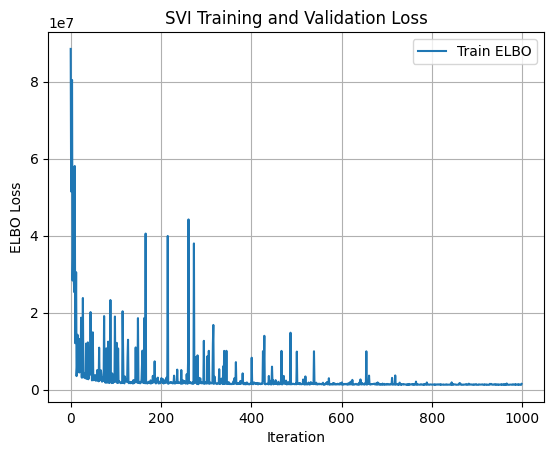

In [22]:
import matplotlib.pyplot as plt
plt.plot(losses, label="Train ELBO")
plt.xlabel('Iteration')
plt.ylabel('ELBO Loss')
plt.title('SVI Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Prediction

In [23]:
from pyro.infer import Predictive
next_data = load_and_prepare(next_month, static, dynamic, seasonal,
                             time_trend, temporal, spatial)

predictive = Predictive(
    model=burglary_model,
    guide=guide,
    num_samples=5_000,
    return_sites=["obs"]
)

occupation_idx     = next_data["occupation_idx"]        # (N,)
X_static     = next_data["X_static"]        # (N, n_static)
X_dynamic    = next_data["X_dynamic"]       # (N, n_dynamic)
X_seasonal   = next_data["X_seasonal"]      # (N, n_seasonal)
X_time_trend = next_data["X_time_trend"]    # (N, n_time_trend)
X_temporal   = next_data["X_temporal"]      # (N, n_temporal)
X_spatial    = next_data["X_spatial"]       # (N, n_spatial)
y            = next_data["y"]               # (N,)

pred_samples = predictive(occupation_idx, X_static, X_dynamic, X_seasonal, X_time_trend, X_temporal, X_spatial)


In [24]:
pred_mean = pred_samples["obs"].float().mean(dim=0)
pred_mean

tensor([0.2692, 0.2362, 0.4640,  ..., 0.2124, 0.6570, 0.4992], device='cuda:0')

In [25]:
lower = pred_samples["obs"].kthvalue(int(0.05 * 1000), dim=0).values
upper = pred_samples["obs"].kthvalue(int(0.95 * 1000), dim=0).values

In [26]:
next_month["pred_mean"]    = pred_mean.cpu().numpy()
next_month["pred_5pct"]    = lower.cpu().numpy()
next_month["pred_95pct"]   = upper.cpu().numpy()
next_month["predicted"] = (
    (next_month["burglaries"] >= next_month["pred_5pct"])
    & 
    (next_month["burglaries"] <= next_month["pred_95pct"])
)

In [27]:
next_month[["occupation_idx", "burglaries", "pred_mean", "pred_5pct", "pred_95pct", "predicted"]]

,occupation_idx,burglaries,pred_mean,pred_5pct,pred_95pct,predicted
170,0,0.0,0.2692,0.0,0.0,True
342,1,1.0,0.2362,0.0,0.0,False
514,2,0.0,0.4640,0.0,0.0,True
686,3,4.0,0.5148,0.0,0.0,False
858,4,1.0,0.4748,0.0,0.0,False
...,...,...,...,...,...,...
858278,4989,0.0,2.5802,0.0,1.0,True
858450,4990,2.0,0.3026,0.0,0.0,False
858622,4991,0.0,0.2124,0.0,0.0,True
858794,4992,0.0,0.6570,0.0,0.0,True


In [28]:
(next_month["predicted"].sum() / len(next_month) * 100).round(2)

np.float64(57.85)

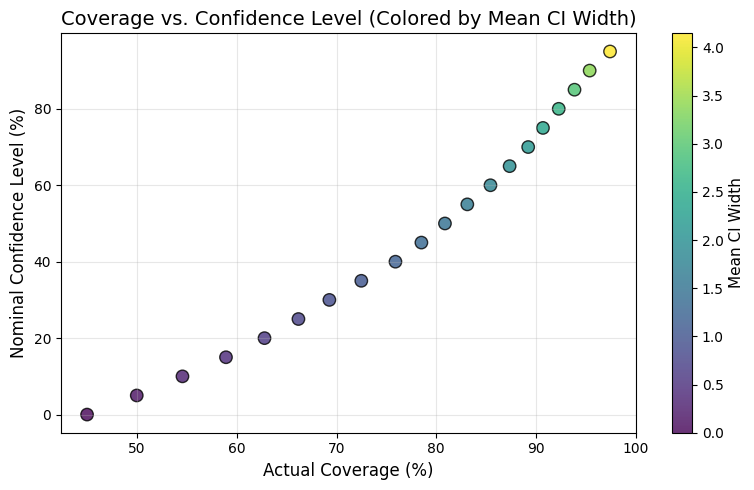

In [29]:
import matplotlib.pyplot as plt
import numpy as np

actual = next_month["burglaries"].values  # shape (N,)

levels = np.arange(0, 1.00, 0.05)

coverages = []   # will store actual coverage at each level
mean_widths = [] # will store mean CI width at each level


num_draws = pred_samples["obs"].shape[0]  # e.g. 1000

for lvl in levels:
    # Compute the index for the lower and upper quantiles in [0 .. num_draws-1]
    lower_q = int(np.floor(((1 - lvl) / 2) * num_draws))
    upper_q = int(np.ceil((1 - (1 - lvl) / 2) * num_draws)) - 1
    
    # Gather the samples at those quantile indices for each location
    lower_vals = pred_samples["obs"].kthvalue(lower_q, dim=0).values.cpu().numpy()
    upper_vals = pred_samples["obs"].kthvalue(upper_q, dim=0).values.cpu().numpy()
    
    # Compute coverage: fraction of actual counts within [lower_vals, upper_vals]
    coverage = np.mean((actual >= lower_vals) & (actual <= upper_vals))
    coverages.append(coverage)
    
    # Compute mean confidence‐interval width
    mean_width = np.mean(upper_vals - lower_vals)
    mean_widths.append(mean_width)

level_perc = [lvl * 100 for lvl in levels]                  # e.g. [50.0, 55.0, ..., 95.0] :contentReference[oaicite:5]{index=5}
coverage_perc = [cov * 100 for cov in coverages]            # e.g. [42.0, 48.0, ...] :contentReference[oaicite:6]{index=6}
mean_widths = np.array(mean_widths)                         # ensure it's a NumPy array for coloring :contentReference[oaicite:7]{index=7}

plt.figure(figsize=(8, 5))

# Use 'c=mean_widths' to color‐code by CI width, and 'cmap' to choose a colormap
scatter = plt.scatter(
    coverage_perc,             # x = actual coverage in %
    level_perc,                # y = nominal confidence level in %
    s=80,                      # marker size = 80 points :contentReference[oaicite:8]{index=8}
    c=mean_widths,             # color = mean CI width :contentReference[oaicite:9]{index=9}
    cmap='viridis',            # use the 'viridis' colormap (perceptually uniform) :contentReference[oaicite:10]{index=10}
    edgecolor='black',         # black edge for better visibility :contentReference[oaicite:11]{index=11}
    alpha=0.8                  # slight transparency = 0.8 :contentReference[oaicite:12]{index=12}
)

# Add a colorbar to show mapping from color to CI width
cbar = plt.colorbar(scatter)
cbar.set_label("Mean CI Width", fontsize=11)           

# ----------------------------------------------------------------------------
# 5. Label axes and title
# ----------------------------------------------------------------------------
plt.xlabel("Actual Coverage (%)", fontsize=12)              	# :contentReference[oaicite:15]{index=15}
plt.ylabel("Nominal Confidence Level (%)", fontsize=12)      	# :contentReference[oaicite:16]{index=16}
plt.title("Coverage vs. Confidence Level (Colored by Mean CI Width)", fontsize=14) 	# :contentReference[oaicite:17]{index=17}

# ----------------------------------------------------------------------------
# 6. Adjust axes limits and add grid
# ----------------------------------------------------------------------------
plt.grid(alpha=0.3)                                         	# light grid lines :contentReference[oaicite:20]{index=20}
plt.tight_layout()           


# Parameter testing

In [30]:
# 1) Use Predictive with num_samples=2000 (or more) to approximate posterior
factors = [
        "b_static", "b_dynamic",
        "b_seasonal", "b_time_tr",
        "b_temporal", "b_spatial"
    ]
factors_map ={
    "b_static": static,
    "b_dynamic": dynamic,
    "b_seasonal": seasonal,
    "b_time_tr": time_trend,
    "b_temporal": temporal,
    "b_spatial": spatial,
}
posterior_samples = Predictive(
    model=burglary_model,
    guide=guide,
    num_samples=5_000,
    return_sites=factors
)(occupation_idx, X_static, X_dynamic, X_seasonal, X_time_trend, X_temporal, X_spatial)


In [31]:
# Loop over each seasonal coefficient and print formatted results
for factor in factors:
    # 2) Suppose we want credible intervals for b_seasonal
    b_seasonal_samples = posterior_samples[factor]

    # 3) Compute posterior mean and standard deviation
    mean_b_seasonal = b_seasonal_samples.mean(dim=0)
    std_b_seasonal  = b_seasonal_samples.std(dim=0)

    # 4) Compute 95% credible intervals via quantiles
    lower_b_seasonal = torch.quantile(b_seasonal_samples, 0.025, dim=0)
    upper_b_seasonal = torch.quantile(b_seasonal_samples, 0.975, dim=0)

    # 5) Check if zero lies outside [lower, upper] ⇒ strong evidence β_j≠0
    significant_seasonal = (lower_b_seasonal > 0) | (upper_b_seasonal < 0)


    for j, col in enumerate(factors_map[factor]):
        mean_val  = mean_b_seasonal[0][j].item()   # Convert to Python float 
        lower_val = lower_b_seasonal[0][j].item()  # Convert to Python float 
        upper_val = upper_b_seasonal[0][j].item()  # Convert to Python float 

        is_significant = (
            (lower_val > 0.0) or 
            (upper_val < 0.0)
        )  # Compare floats, not tensors 

        print(
            f"{col}:\n"
            f"mean={mean_val:.3f}, \n"
            f"95% CI=[{lower_val:.3f}, {upper_val:.3f}], \n"
            f"significant={'Yes' if is_significant else 'No'}\n\n\n"
        )  # Formatted print using Python floats 


Public Transport Accessibility Levels|Number of people in each PTAL level:|2:
mean=1.079, 
95% CI=[1.015, 1.138], 
significant=Yes



Ethnic Group|BAME (%):
mean=-0.408, 
95% CI=[-0.445, -0.372], 
significant=Yes



Household Composition|% One person household:
mean=0.896, 
95% CI=[0.838, 0.953], 
significant=Yes



Parking locations:
mean=-0.020, 
95% CI=[-0.045, 0.005], 
significant=No



Public Transport Accessibility Levels|% 0-1 (poor access)|Level3_65:
mean=0.258, 
95% CI=[0.207, 0.308], 
significant=Yes



Public Transport Accessibility Levels|Number of people in each PTAL level:|5:
mean=0.732, 
95% CI=[0.692, 0.773], 
significant=Yes



Household Composition|% Other multi person household:
mean=0.465, 
95% CI=[0.422, 0.508], 
significant=Yes



Leisure locations:
mean=-0.017, 
95% CI=[-0.048, 0.014], 
significant=No



Public Transport Accessibility Levels|Number of people in each PTAL level:|6b:
mean=0.683, 
95% CI=[0.616, 0.749], 
significant=Yes



Car or van availability|Ca